# Homework 3: Text classification with Maximum Entropy model

Can we detect sarcasm in news article headlines?

In this homework, we will formulate a Maximum Entropy (MaxEnt) models to classify news headlines into sarcastic or not sarcastic.

## Bibliography

1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019). https://arxiv.org/pdf/1908.07414.pdf
2. McCallum, Andrew, and Kamal Nigam. "A comparison of event models for naive bayes text classification." AAAI-98 workshop on learning for text categorization. Vol. 752. No. 1. 1998. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf
3. Kaggle dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

## News article headlines dataset

We will use the "Sarcasm headlines" dataset, collected by Ref. (1), and downloaded from Kaggle (3). The dataset consists of a series of headlines from news articles, classified as either being sarcastic, or not. The authors of (1) collected news from two sources: a serious news website (https://www.huffingtonpost.com), and an online newspaper that publishes satirical articles (https://www.theonion.com/). Headlines form the The Huffingtonpost were classified as non-sarcastic (`is_sarcastic=0`), and headlines from The Onion were classified as sarcastic (`is_sarcastic=1`).

**Data**. Two files have been prepared for this exercise: `train_data.json` containing the dataset that you will use to train the model, and `tests_data.json`, that you will use to evaluate the performance of the model. The following code will download these two data files for you.  

In [1]:
import json
import numpy as np
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt 



def parse_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        for l in file:
            yield json.loads(l)

train_data = list(parse_data('data-2/train_data.json'))
tests_data = list(parse_data('data-2/tests_data.json'))
all_data = train_data + tests_data

# Use less train data! (Question 5)
# train_data, tests_data = all_data[:100], all_data[100:]
# train_data, tests_data = all_data[:1000], all_data[1000:]
# train_data, tests_data = all_data[:10000], all_data[10000:]

# again, making the plots is annoying without acutally substetting the data
train_data_100, tests_data_100 = all_data[:100], all_data[100:]
train_data_1000, tests_data_1000 = all_data[:1000], all_data[1000:]
train_data_10000, tests_data_10000 = all_data[:10000], all_data[10000:]

# print some examples
print('train data:')
for d in train_data[:3]:
    print(d)
print('tests data:')
for d in tests_data[:3]:
    print(d)

train data:
{'is_sarcastic': 0, 'headline': 'sónar festival offers more than you might expect', 'article_link': 'https://www.huffingtonpost.com/entry/sonar-festival-offers-mor_b_5507780.html'}
{'is_sarcastic': 1, 'headline': '2013 year in review photo essay shaping up to be quite horrific', 'article_link': 'https://www.theonion.com/2013-year-in-review-photo-essay-shaping-up-to-be-quite-1819575009'}
{'is_sarcastic': 1, 'headline': 'angolan war criminal called in as character witness to manafort fraud trial', 'article_link': 'https://politics.theonion.com/angolan-war-criminal-called-in-as-character-witness-to-1828084812'}
tests data:
{'is_sarcastic': 1, 'headline': "mother comes pretty close to using word 'streaming' correctly", 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}
{'is_sarcastic': 1, 'headline': 'shadow government getting too large to meet in marriott conference room b', 'article_link': 'https://politics.theonion.co

As you can see, each data point is a Python dictionary with three fields:

1. `'is_sarcastic'`, a binary value, equal to 1 if the headline is sarcastic, and equal to 0 otherwise.
2. `'headline'`, the news article headline.
3. `'article_link'`, a link to the original news article. Although in principle inspecting the news article itself can provide more information, in this tutorial we will **not** do this. For simplicity, please ignore the `'article_link'` field.

In [2]:
# number of train and testing data points
print(len(train_data))
print(len(tests_data))

22895
5724


In [3]:
len(train_data) / (len(train_data) + len(tests_data))

0.7999930116356266

In [4]:
# access 'headline' of the news article #6 from the training dataset
train_data[5]['headline']

'world will miss goal for universal education by 50 years: un'

In [5]:
# collect all words in a single list (set discards duplicates)
all_words = list(set(word for doc in all_data for word in doc['headline'].split()))

# total number of words
L = len(all_words)
print(L)

38234


In [6]:
# dictionary giving the index of a word in the list
word_index = {word: i for (i, word) in enumerate(all_words)}

In [7]:
# index of word 'expertise' in the list of all words
word_index['expertise']

8335

## Question 1

We represent a headline as a binary vector, $\vec\sigma=\{σ_i\}_{i=1}^L$, where $σ_i = 1$ if word $i$ appears in the headline, and $σ_i = 0$ otherwise. The vector $\vec\sigma$ is of length $L$, which equals the total number of words considered (the vocabulary, `all_words` in the code above).

**Q1a):** This representation of texts is missing important aspects of language. Can you give a simple argument for why?

We will formulate two maximum entropy models (one for each class) matching the empirical frequencies of words in the train dataset for each class. Let $c=0,1$ be our label ($c=1$ for sarcastic headlines, $c=0$ otherwise). For each word, we define its empirical frequency in headlines of class $c$ as follows:

$$p_i(c) = \frac{1}{M_c}\sum_{\vec\sigma\in \mathcal D_c}\sigma_i$$

where $\mathcal D_c$ is the set of headlines of class $c$, and $M_c=|\mathcal D_c|$ is their number in our dataset. Notice that if a word appears more than once in a headline, it will still be counted as one. Since some rare words occur very few times in the data, it is recommended to add a *pseudo-count*,

$$p_i(c) = \frac{1}{M_c+1}\left(\sum_{\vec\sigma\in \mathcal D_c}\sigma_i + 1\right)$$

This avoids unintentional divisions by zero below. This procedure will be better justified in the following lectures when we discuss the role of the prior distributtion.

As shown in the lecture, the MaxEnt model matching these empirical frequencies for each class, is of the form:

$$P(\vec{\sigma}|c) = \frac{e^{\sum_i h_i(c)\sigma_i}}{Z(c)}$$

where

$$Z (c) = \sum_{\vec{\sigma}}e^{\sum_i h_i (c) \sigma_i} = \prod_i
\sum_{\sigma=0,1}e^{h_i (c) \sigma_i} = \prod_i (1 + e^{h_i (c)})$$

and the fields $h_i(c)$ are such that the moment-matching constraints are satisfied.

**Q1b)** Write the expression of the fields $h_i(c)$ to satisfy the moment-matching constraints $\langle \sigma_i \rangle_c = p_i(c)$, where $\langle . \rangle_c$ indicates the expectations under the model.

**Q1c)** Estimate the fields $h_i(c)$ for all the words in the full dataset, but using only the training data to estimate the empirical frequencies $p_i(c)$ (use the pseudocount, as explained above). Explain why the pseudo-count is necessary. *Hint: Consider a word that occurs in the testset, but not in the training set.*

In [8]:
# subset the data
sarcastic_train= [doc for doc in train_data if doc['is_sarcastic'] == 1]
non_sarcastic_train = [doc for doc in train_data if doc['is_sarcastic'] == 0]

#making the new plots is annoying without acutally just subsetting the data

sarcastic_train_100 = [doc for doc in train_data_100 if doc['is_sarcastic'] == 1]
non_sarcastic_train_100 = [doc for doc in train_data_100 if doc['is_sarcastic'] == 0]

sarcastic_train_1000 = [doc for doc in train_data_1000 if doc['is_sarcastic'] == 1]
non_sarcastic_train_1000 = [doc for doc in train_data_1000 if doc['is_sarcastic'] == 0]

sarcastic_train_10000 = [doc for doc in train_data_10000 if doc['is_sarcastic'] == 1]
non_sarcastic_train_10000 = [doc for doc in train_data_10000 if doc['is_sarcastic'] == 0]


In [9]:
sarcastic_test = [doc for doc in tests_data if doc['is_sarcastic'] == 1]
non_sarcastic_test = [doc for doc in tests_data if doc['is_sarcastic'] == 0]

sarcastic_all = [doc for doc in all_data if doc['is_sarcastic'] == 1]
non_sarcastic_all = [doc for doc in all_data if doc['is_sarcastic'] == 0]

In [10]:

def to_vec(doc, index=word_index, vocab_size=L):
    '''Helper function that vectorizes a headline'''
    # create an empty vector of size L (vocab size)
    vec = np.zeros(vocab_size)
    
    # split the headline into words
    words = doc.split()

    # increment the count of each word and add 1 to the vector at the corresponding positon
    for word in words:
        if vec[index[word]] < 1: # but no more than 1
            vec[index[word]] += 1

    return vec


def field_estimate(data, vocab_size=L):
    '''This funciton computes the field of a class in the data, using the 
    Pseudo-count'''
    # define the occurances of the class in the data
    M_c = len(data) + 1
    
    # create an empty vector of size L (vocab size)
    vec = np.zeros(vocab_size)

    #iterate over the data, adding the generated vectors
    for doc in data:
        vec += to_vec(doc['headline'])
    
    #adjust for the pseudo-count
    vec += 1

    p_c = vec / M_c
    
    #convert from division because division sucks
    return np.log(p_c) - np.log(1 - p_c)


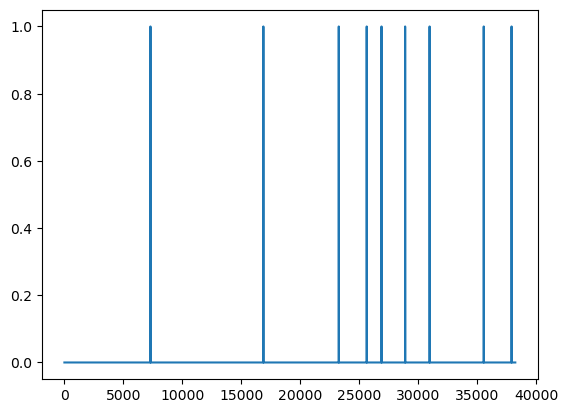

In [11]:
plt.rcParams.update({'font.size': 10})
plt.plot(to_vec(sarcastic_test[0]['headline']))

In [12]:
field_sarcastic_train = field_estimate(sarcastic_train)
field_non_sarcastic_train = field_estimate(non_sarcastic_train)

field_sarcastic_train_100 = field_estimate(sarcastic_train_100)
field_non_sarcastic_train_100 = field_estimate(non_sarcastic_train_100)

field_sarcastic_train_1000 = field_estimate(sarcastic_train_1000)
field_non_sarcastic_train_1000 = field_estimate(non_sarcastic_train_1000)

field_sarcastic_train_10000 = field_estimate(sarcastic_train_10000)
field_non_sarcastic_train_10000 = field_estimate(non_sarcastic_train_10000)

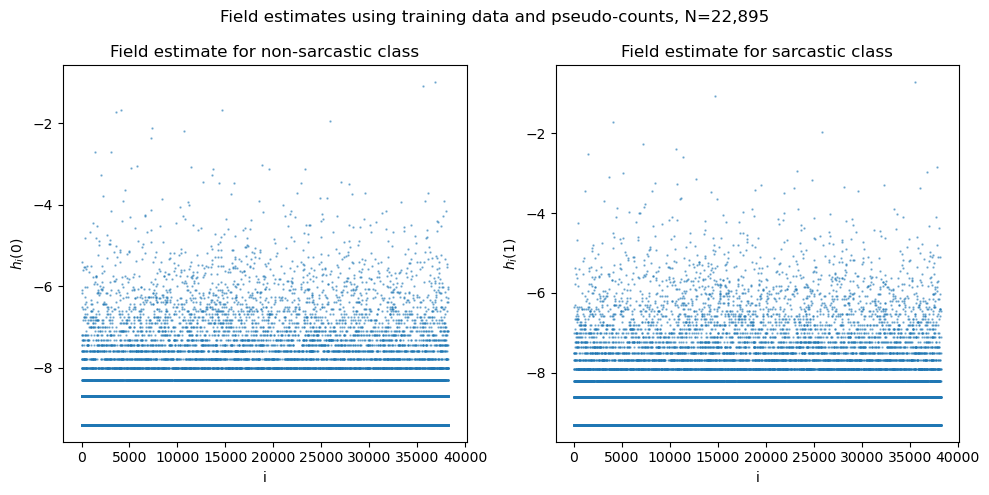

In [13]:
#Plotting the pseudo-fields

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter([i for i in range(len(field_non_sarcastic_train))], field_non_sarcastic_train, s=0.5, alpha=0.5)
ax1.set_xlabel('i')
ax1.set_ylabel(r'$h_i(0)$')
ax1.set_title('Field estimate for non-sarcastic class')

ax2.scatter([i for i in range(len(field_sarcastic_train))], field_sarcastic_train, s=0.5, alpha=0.5)
ax2.set_xlabel('i')
ax2.set_ylabel(r'$h_i(1)$')
ax2.set_title('Field estimate for sarcastic class')

fig.suptitle('Field estimates using training data and pseudo-counts, N=22,895')
fig.tight_layout()

# fig.savefig('fields.png', dpi=600)



## Question 2.

**Q2a)** Plot the histogram of $\log P(\vec\sigma|c=1)$ for the sarcastic headlines, and for the serious headlines (in the same plot), for the test dataset. Are the histograms different?

**Q2b)** Plot the histogram of $\log\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}$ for the sarcastic headlines, and for the serious headlines. Are the histograms different?

**Bonus:** Same as b), but for $\log P(\vec\sigma|c=0)$.

**Q2c)** To give a quantitative measure of the separation of the two histograms above, you can compute the difference in means, normalized by the geometric mean of their standard deviations:

$$\frac{|\langle x\rangle - \langle y\rangle|}{\sqrt{\sigma_x \sigma_y}}$$

where $x,y$ denote the two kind of log-likelihoods or log-likelihood differences, considered in a), b).

In [14]:
#Q2a
def log_conditional(data, fields):
    '''This function computes the log conditional probability of the provided data
    This funciton uses the log property that log(a/b) = log(a) - log(b) 
    and log(a*b) = log(a) + log(b)'''

    log_z = np.sum(np.log(1 + np.exp(fields))) #converted from product to sum
    
    probs = []

    for doc in data:
        vec = to_vec(doc['headline'])
        sums = np.dot(fields, vec)
        probs.append(sums - log_z)
    

    return np.array(probs)

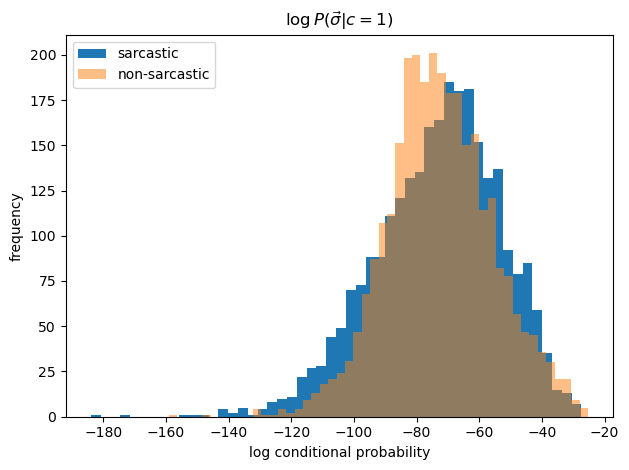

In [15]:
#plotting
fig, ax = plt.subplots()
ax.hist(log_conditional(sarcastic_test, field_sarcastic_train ), bins=50, label='sarcastic')
ax.hist(log_conditional(non_sarcastic_test, field_sarcastic_train), bins=50, alpha=0.5, label='non-sarcastic')
ax.set_xlabel('log conditional probability')
ax.set_ylabel('frequency')

ax.set_title(r'$\log P(\vec{\sigma} | c = 1)$')

plt.legend(loc='upper left')
plt.tight_layout()

# plt.savefig('log_conditional_c1.png', dpi=600)
plt.show()

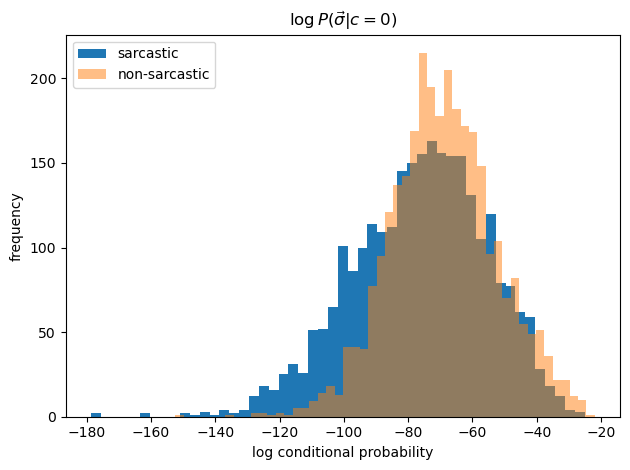

In [16]:
# Bonus
#plotting
fig, ax = plt.subplots()
ax.hist(log_conditional(sarcastic_test, field_non_sarcastic_train), bins=50, label='sarcastic')
ax.hist(log_conditional(non_sarcastic_test, field_non_sarcastic_train), bins=50, alpha=0.5, label='non-sarcastic')
ax.set_xlabel('log conditional probability')
ax.set_ylabel('frequency')

ax.set_title(r'$\log P(\vec{\sigma} | c = 0)$')

plt.legend(loc='upper left')
plt.tight_layout()

# plt.savefig('log_conditional_c0.png', dpi=600)
plt.show()


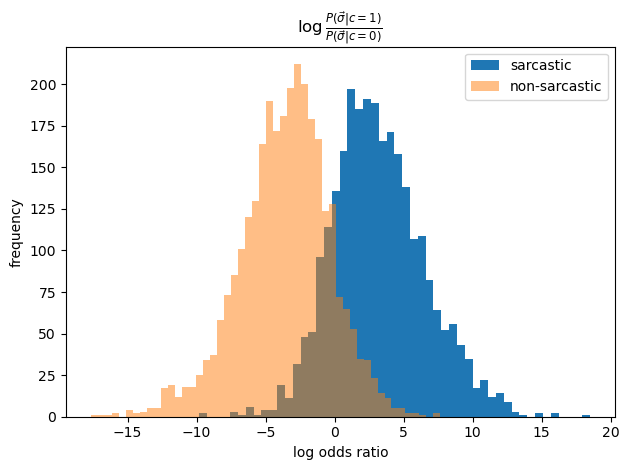

In [17]:
#Q2b

ratio_s = np.array(log_conditional(sarcastic_test, field_sarcastic_train)) - np.array(log_conditional(sarcastic_test, field_non_sarcastic_train))
ratio_ns = np.array(log_conditional(non_sarcastic_test, field_sarcastic_train)) - np.array(log_conditional(non_sarcastic_test, field_non_sarcastic_train))
fig, ax = plt.subplots()

ax.hist(ratio_s, bins=50, label='sarcastic')
ax.hist(ratio_ns, bins=50, alpha=0.5, label='non-sarcastic')
ax.set_xlabel('log odds ratio')
ax.set_ylabel('frequency')
ax.set_title(r'$\log \frac{P(\vec{\sigma} | c = 1)}{P(\vec{\sigma} | c = 0)}$')

ax.legend(loc='best')
fig.tight_layout()

# plt.savefig('log_odds_ratio.png', dpi=600)




In [18]:
#Q2c 

#quantitative measure of the difference when the category is 1

x_1 = log_conditional(sarcastic_test, field_sarcastic_train)
y_1 = log_conditional(non_sarcastic_test, field_sarcastic_train)

diff_1 = np.abs(np.mean(x_1) - np.mean(y_1)) / np.sqrt(np.std(x_1) * np.std(y_1))
diff_1

x_0 = log_conditional(sarcastic_test, field_non_sarcastic_train)
y_0 = log_conditional(non_sarcastic_test, field_non_sarcastic_train)

diff_0 = np.abs(np.mean(x_0) - np.mean(y_0)) / np.sqrt(np.std(x_0) * np.std(y_0))

print(diff_1, diff_0) 



x_diff_1 = np.abs(np.mean(ratio_ns) - np.mean(ratio_s)) / np.sqrt(np.std(ratio_ns) * np.std(ratio_s))
print(x_diff_1)

0.04209083908979738 0.4083446807220005
2.0577830492984375


## Question 3

**Q3a)** Using Bayes theorem, compute the ratio $P(c=1|\vec{\sigma})/P(c=0|\vec{\sigma})$ for the headlines in your testing set (note that $P(\vec{\sigma})$ cancels). To obtain an empirical estimate of $P(c)$, you can count the number of headlines in each class of the training set. Your classifier will use these ratios as the scores to predict the label of a headline.

**Q3b)** How accurate is this classifier? To quantify this, plot the Receiver Operating Characteristic Curve (ROC) and compute the Area Under the Curve (AUC). See Appendix for an explanation of the ROC and the AUC.

*Hint: The ROC curve is easier to obtain if you assume that the scores are sorted. You can also use the functions `roc_curve` and `auc` from the python package `sklearn`.*

**Bonus:** What is the ROC curve and AUC of a random classifier (that emits random labels for each headline)? What is the ROC curve and AUC of a perfect classifier (that emits the correct label for every headline)?

**Bonus:** Describe the connection between the areas under the histogram  curves of exercise 2 from d) and the AUC.

**(BONUS) Q3c)** Estimate the mutual information between the headline and the label,

$$MI(\vec\sigma,c)=\sum_{\vec\sigma,c}P(\vec\sigma,c)\ln\left(\frac{P(\vec\sigma,c)}{P(\vec\sigma)P(c)}\right)$$

Using the exact expression is intractable. However, you can obtain a practical estimate by approximating the outer average over the model distribution $P(\vec\sigma,c)$, with an empirical average over your data,

$$MI(\vec\sigma,c)\approx\frac{1}{M}\sum_d\ln\left(\frac{P(\vec\sigma_d,c_d)}{P(\vec\sigma_d)P(c_d)}\right)$$

where the sum over $d$ goes over the labeled headlines $\vec\sigma_d,c_d$ of your dataset. Estimate $MI(\vec\sigma,c)$ using this approximate expression for your training set and your testing set.

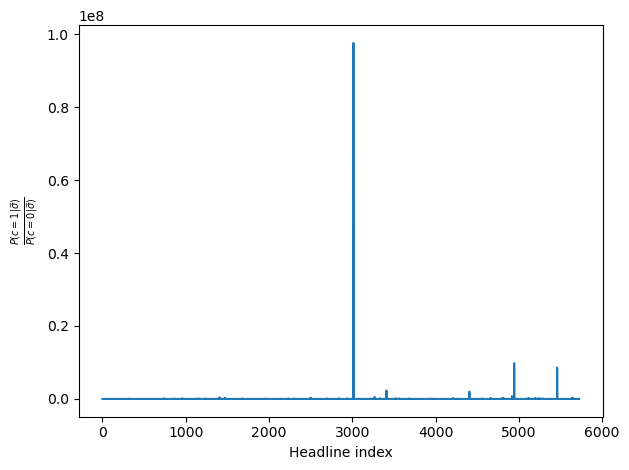

In [19]:

prior_s = (len(sarcastic_train)/len(train_data))
prior_ns = (len(non_sarcastic_train)/len(train_data)) 

pcond_s = np.exp(log_conditional(tests_data, field_sarcastic_train))
pcond_ns = np.exp(log_conditional(tests_data, field_non_sarcastic_train))



def avoid_zero_div(x, y):
    dividearray = []
    for i, j in zip(x, y):
        if i != 0 and j != 0: 
            dividearray.append(i/j)
        else: dividearray.append(0)
    return np.array(dividearray)

y = avoid_zero_div(pcond_s * prior_s, pcond_ns * prior_ns)

fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Headline index')
ax.set_ylabel(r'$\frac{P(c=1|\vec{\sigma})}{P(c=0|\vec{\sigma})}$')
ax.set_title('')

fig.tight_layout()
# plt.savefig('odds_values.png', dpi=600)




In [20]:
print(np.where(y == np.max(y))[0][0], np.where(y == np.min(y))[0][0])

print(tests_data[np.where(y == np.max(y))[0][0]]['headline'])

print(tests_data[np.where(y == np.min(y))[0][0]]['headline'])

3013 4346
nation wishes area man were a creep, but, ugh, he's actually really fucking nice
here's what cops and their supporters are saying about the sandra bland arrest video


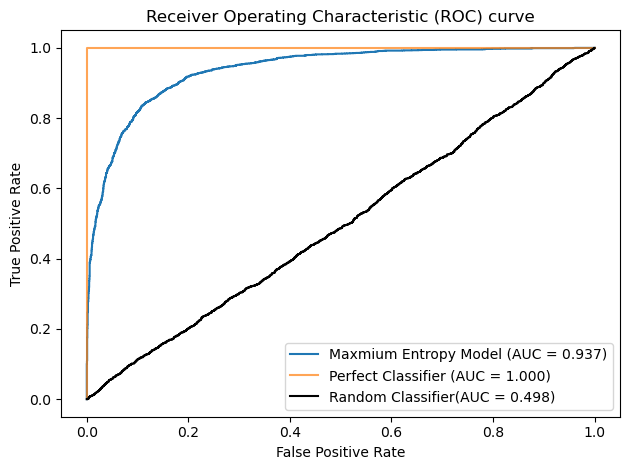

In [21]:
#Q3b ROC and AUC

fpr, tpr, thresholds = roc_curve([doc['is_sarcastic'] for doc in tests_data], y)
    
# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)


y_random = np.random.rand(len(tests_data))
fpr_random, tpr_random, _ = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_random)
roc_auc_random = auc(fpr_random, tpr_random)

y_perfect = [doc['is_sarcastic'] for doc in tests_data]
fpr_perfect, tpr_perfect, _ = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_perfect)
roc_auc_perfect = auc(fpr_perfect, tpr_perfect)

# Create plot
fig, ax = plt.subplots()
ax.plot(fpr, tpr,  
         label=f'Maxmium Entropy Model (AUC = {roc_auc:.3f})')
ax.plot(fpr_perfect, tpr_perfect, alpha=0.7, label=f'Perfect Classifier (AUC = {roc_auc_perfect:.3f})')

ax.plot(fpr_random, tpr_random, color='black',
         label=f'Random Classifier(AUC = {roc_auc_random:.3f})')
ax.legend(loc='lower right')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) curve')

fig.tight_layout()
# fig.savefig('roc_auc.png', dpi=600)



In [22]:
#Mutual Information
def mutual_information(data):
    M = len(data)

    c0 = [doc for doc in data if doc['is_sarcastic'] == 0]
    c1 = [doc for doc in data if doc['is_sarcastic'] == 1]

    prior_c0 = len(c0) / M
    prior_c1 = len(c1) / M

    field_estimate_c0 = field_estimate(c0)
    field_estimate_c1 = field_estimate(c1)

    # Conditional probabilities P(vec_sigma | c=0) and P(vec_sigma | c=1) for each sample
    log_pcond_c0 = log_conditional(data, field_estimate_c0)  # log P(vec_sigma | c=0)
    log_pcond_c1 = log_conditional(data, field_estimate_c1)  # log P(vec_sigma | c=1)

    # Initialize mutual information
    mi = 0.0

    # Loop over each sample in data to calculate MI contributions
    for i, doc in enumerate(data):
        is_sarcastic = doc['is_sarcastic']


        if is_sarcastic == 1:
            log_joint_prob = log_pcond_c1[i] + np.log(prior_c1)  # P(vec_sigma, c=1)
            log_prior = np.log(prior_c1)
        else:
            log_joint_prob = log_pcond_c0[i] + np.log(prior_c0)  # P(vec_sigma, c=0)
            log_prior = np.log(prior_c0)


        log_p_vec = np.logaddexp(log_pcond_c0[i] + np.log(prior_c0), log_pcond_c1[i] + np.log(prior_c1))

        # Calculate MI contribution for this sample
        mi += log_joint_prob - (log_p_vec + log_prior)

    # Average over all samples
    mi /= M
    return mi

# For the training set
mi_test = mutual_information(tests_data)
mi_train = mutual_information(train_data)

print(mi_train, mi_test)


0.5529391741948846 0.5706389006336805


In [23]:
p_c1 = len([doc for doc in train_data if doc['is_sarcastic'] == 1])/len(train_data)
p_c0 = len([doc for doc in train_data if doc['is_sarcastic'] == 0])/len(train_data)

H = -p_c1 * np.log2(p_c1) - p_c0 * np.log2(p_c0)
print(p_c1, p_c0, H, mi_train, mi_test)

0.4769600349421271 0.5230399650578729 0.9984677770458245 0.5529391741948846 0.5706389006336805


## Question 4 (BONUS)

Compute the Kullback-Leiber (KL) divergences between the 2 models,

$$D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1))$$

and

$$D_{KL}(P(\vec\sigma|c=1) || P(\vec\sigma|c=0))$$

Why are the two KL divergences different?

**Q4a)** Show that the KL divergences above, are sums of contributions for each word. Derive analytical expressions, as functions of the fields $h_i(c)$ in each case.

**Q4b)** Consider the task of classifying a newspaper as publishing sarcastic or non-sarcastic news articles. Estimate (approximatey) how many headlines your model will need to guess the correct classification confidently (with a probability of error below $10^{-10}$), assuming that in reality, i) the news-source publishes sarcastic headlines, or ii) the news-source publishes serious articles.

**Q4c)** To model different newspapers, construct datasets $D_1(c=1), D_2(c=1), \dots, D_{10}(c=1)$ consisting of different numbers of sarcastic headlines only, by taking the first 5, 10, 15, ..., 50, sarcastic headlines from the test dataset. Similarly, construct datasets $D_1(c=0), D_2(c=0), \dots, D_{10}(c=0)$ consisting of serious headlines only, by taking the first 5, 10, 15, .. 50 serious headlines from the test dataset. Compute the log-likelihood of each of these datasets under the two models $P(\vec\sigma|c=0,1)$.

**Q4d)** Plot the log-likelihood difference versus the number of headlines in each of the datasets constructed in c). What is the expected slope of this plot?

**Q4e)** Plot the log-likelihood difference per headlines (i.e., divided by number of headlines), versus the number of headlines in each of the datasets constructed in c). What is the expected asymptotic of this plot?

In [24]:
def lognan(x):
    '''This function returns the log of x, with the exception that log(0) = 0,
    log(nan) = 0, and log(inf) = 0'''
    newarray = []
    for i in x:
        if (i == 0) or (np.isnan(i)) or (np.isinf(i)):
            newarray.append(0)
        else:
            newarray.append(np.log(i))
    return np.array(newarray)

In [25]:
def sum_kl(gt_field, comp_field):
    x1 = np.exp(gt_field)/(1 + np.exp(gt_field))
    x2 = gt_field - comp_field
    x3 = np.log((1 + np.exp(comp_field)) / (1 + np.exp(gt_field)))

    return np.sum((x1 * x2) + x3)


sarcastic_gt = sum_kl(field_sarcastic_train, field_non_sarcastic_train)
non_sarcastic_gt = sum_kl(field_non_sarcastic_train, field_sarcastic_train)

sarcastic_gt,non_sarcastic_gt

(4.964837086829271, 4.748140242748091)

In [26]:
def Chernoff_bound(threshold, kl):
    return -np.log(threshold)/kl


Chernoff_bound(1e-10, sarcastic_gt), Chernoff_bound(1e-10, non_sarcastic_gt)

#NB, for fields computed with small sample data, the KL Divergence is uselss, so we Chernoff bound, based on KL, will also be useless

(4.637785797850946, 4.849446257428516)

In [27]:
datasets = {'c0': {}, 'c1': {}}
steps = range(5, 55, 5)
for step in steps:
    for category in datasets:
        if category == 'c0':
            datasets[category][step] = non_sarcastic_test[:step]
        else:
            datasets[category][step] = sarcastic_test[:step]

Text(0.5, 1.0, 'Average log likelihood difference between sarcastic and non-sarcastic class, \n given the category of the data')

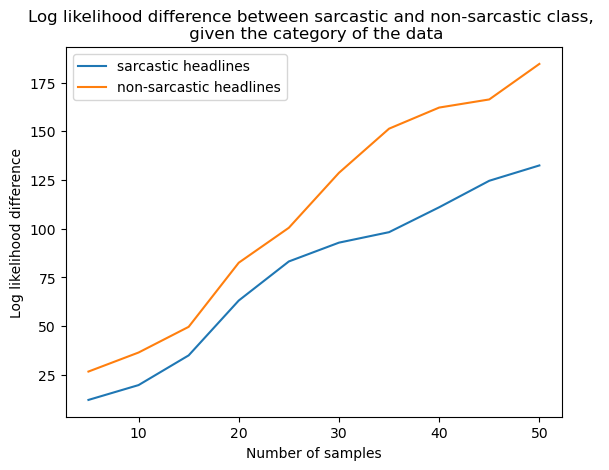

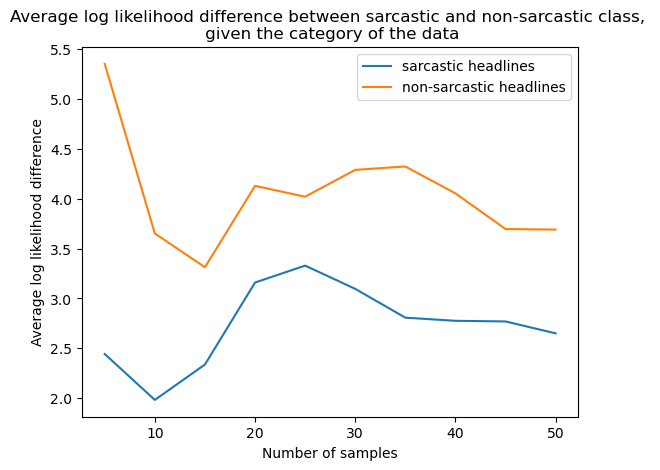

In [28]:
#Q4c)

def log_likelyhood(log_data_probs):
    return np.sum(log_data_probs)

LLs = {'c0': {}, 'c1': {}}

for category in datasets:
    for step in steps:
        data = datasets[category][step]
        log_data_c0 = log_conditional(data, field_non_sarcastic_train)
        log_data_c1 = log_conditional(data, field_sarcastic_train)
        if category == 'c0':
            LLs[category][step] = np.array([log_likelyhood(log_data_c0), log_likelyhood(log_data_c1)])
        else:
            LLs[category][step] = np.array([log_likelyhood(log_data_c1), log_likelyhood(log_data_c0), ])

c0_data = LLs['c0']
c1_data = LLs['c1']

difs_0 = []
for i in c0_data:
    difs_0.append(c0_data[i][0] - c0_data[i][1])
difs_0 = np.array(difs_0)
difs_1 = []
for i in c1_data:
    difs_1.append(c1_data[i][0] - c1_data[i][1])
difs_1 = np.array(difs_1)


fig, ax = plt.subplots()
ax.plot(steps, difs_1, label='sarcastic headlines')
ax.plot(steps, difs_0, label='non-sarcastic headlines')
ax.set_xlabel('Number of samples')
ax.set_ylabel('Log likelihood difference')
ax.legend(loc='best')
ax.set_title('Log likelihood difference between sarcastic and non-sarcastic class, \n given the category of the data')
# fig.savefig('log_likelyhood_diff.png', dpi=600)

avg_ll_diff_proper_c0 = difs_0/np.array(steps)
avg_ll_diff_proper_c0

avg_ll_diff_proper_c1 = difs_1/np.array(steps)

fig, ax = plt.subplots()

ax.plot(steps, avg_ll_diff_proper_c1, label='sarcastic headlines')
ax.plot(steps, avg_ll_diff_proper_c0, label='non-sarcastic headlines')
ax.set_xlabel('Number of samples')
ax.set_ylabel('Average log likelihood difference')
ax.legend(loc='best')
ax.set_title('Average log likelihood difference between sarcastic and non-sarcastic class, \n given the category of the data')
# fig.savefig('avg_log_likelyhood_diff.png', dpi=600)


## Question 5

In the previous exercises, your training dataset contained $\approx 80\%$ of headlines in your entire dataset. Repeat exericses 1-4, but reducing your training dataset to only the first 100, 1000, and 10000 headlines, assigning all the remaining headlines to the testing set. Discuss the impact on the performance of the model of the limited training data. Plot the AUC for the different sizes of training data, and the score computed in Q2c. *Hint: You can just modify the definition of `train_data` in the first cell of this notebook and re-run everything else!*

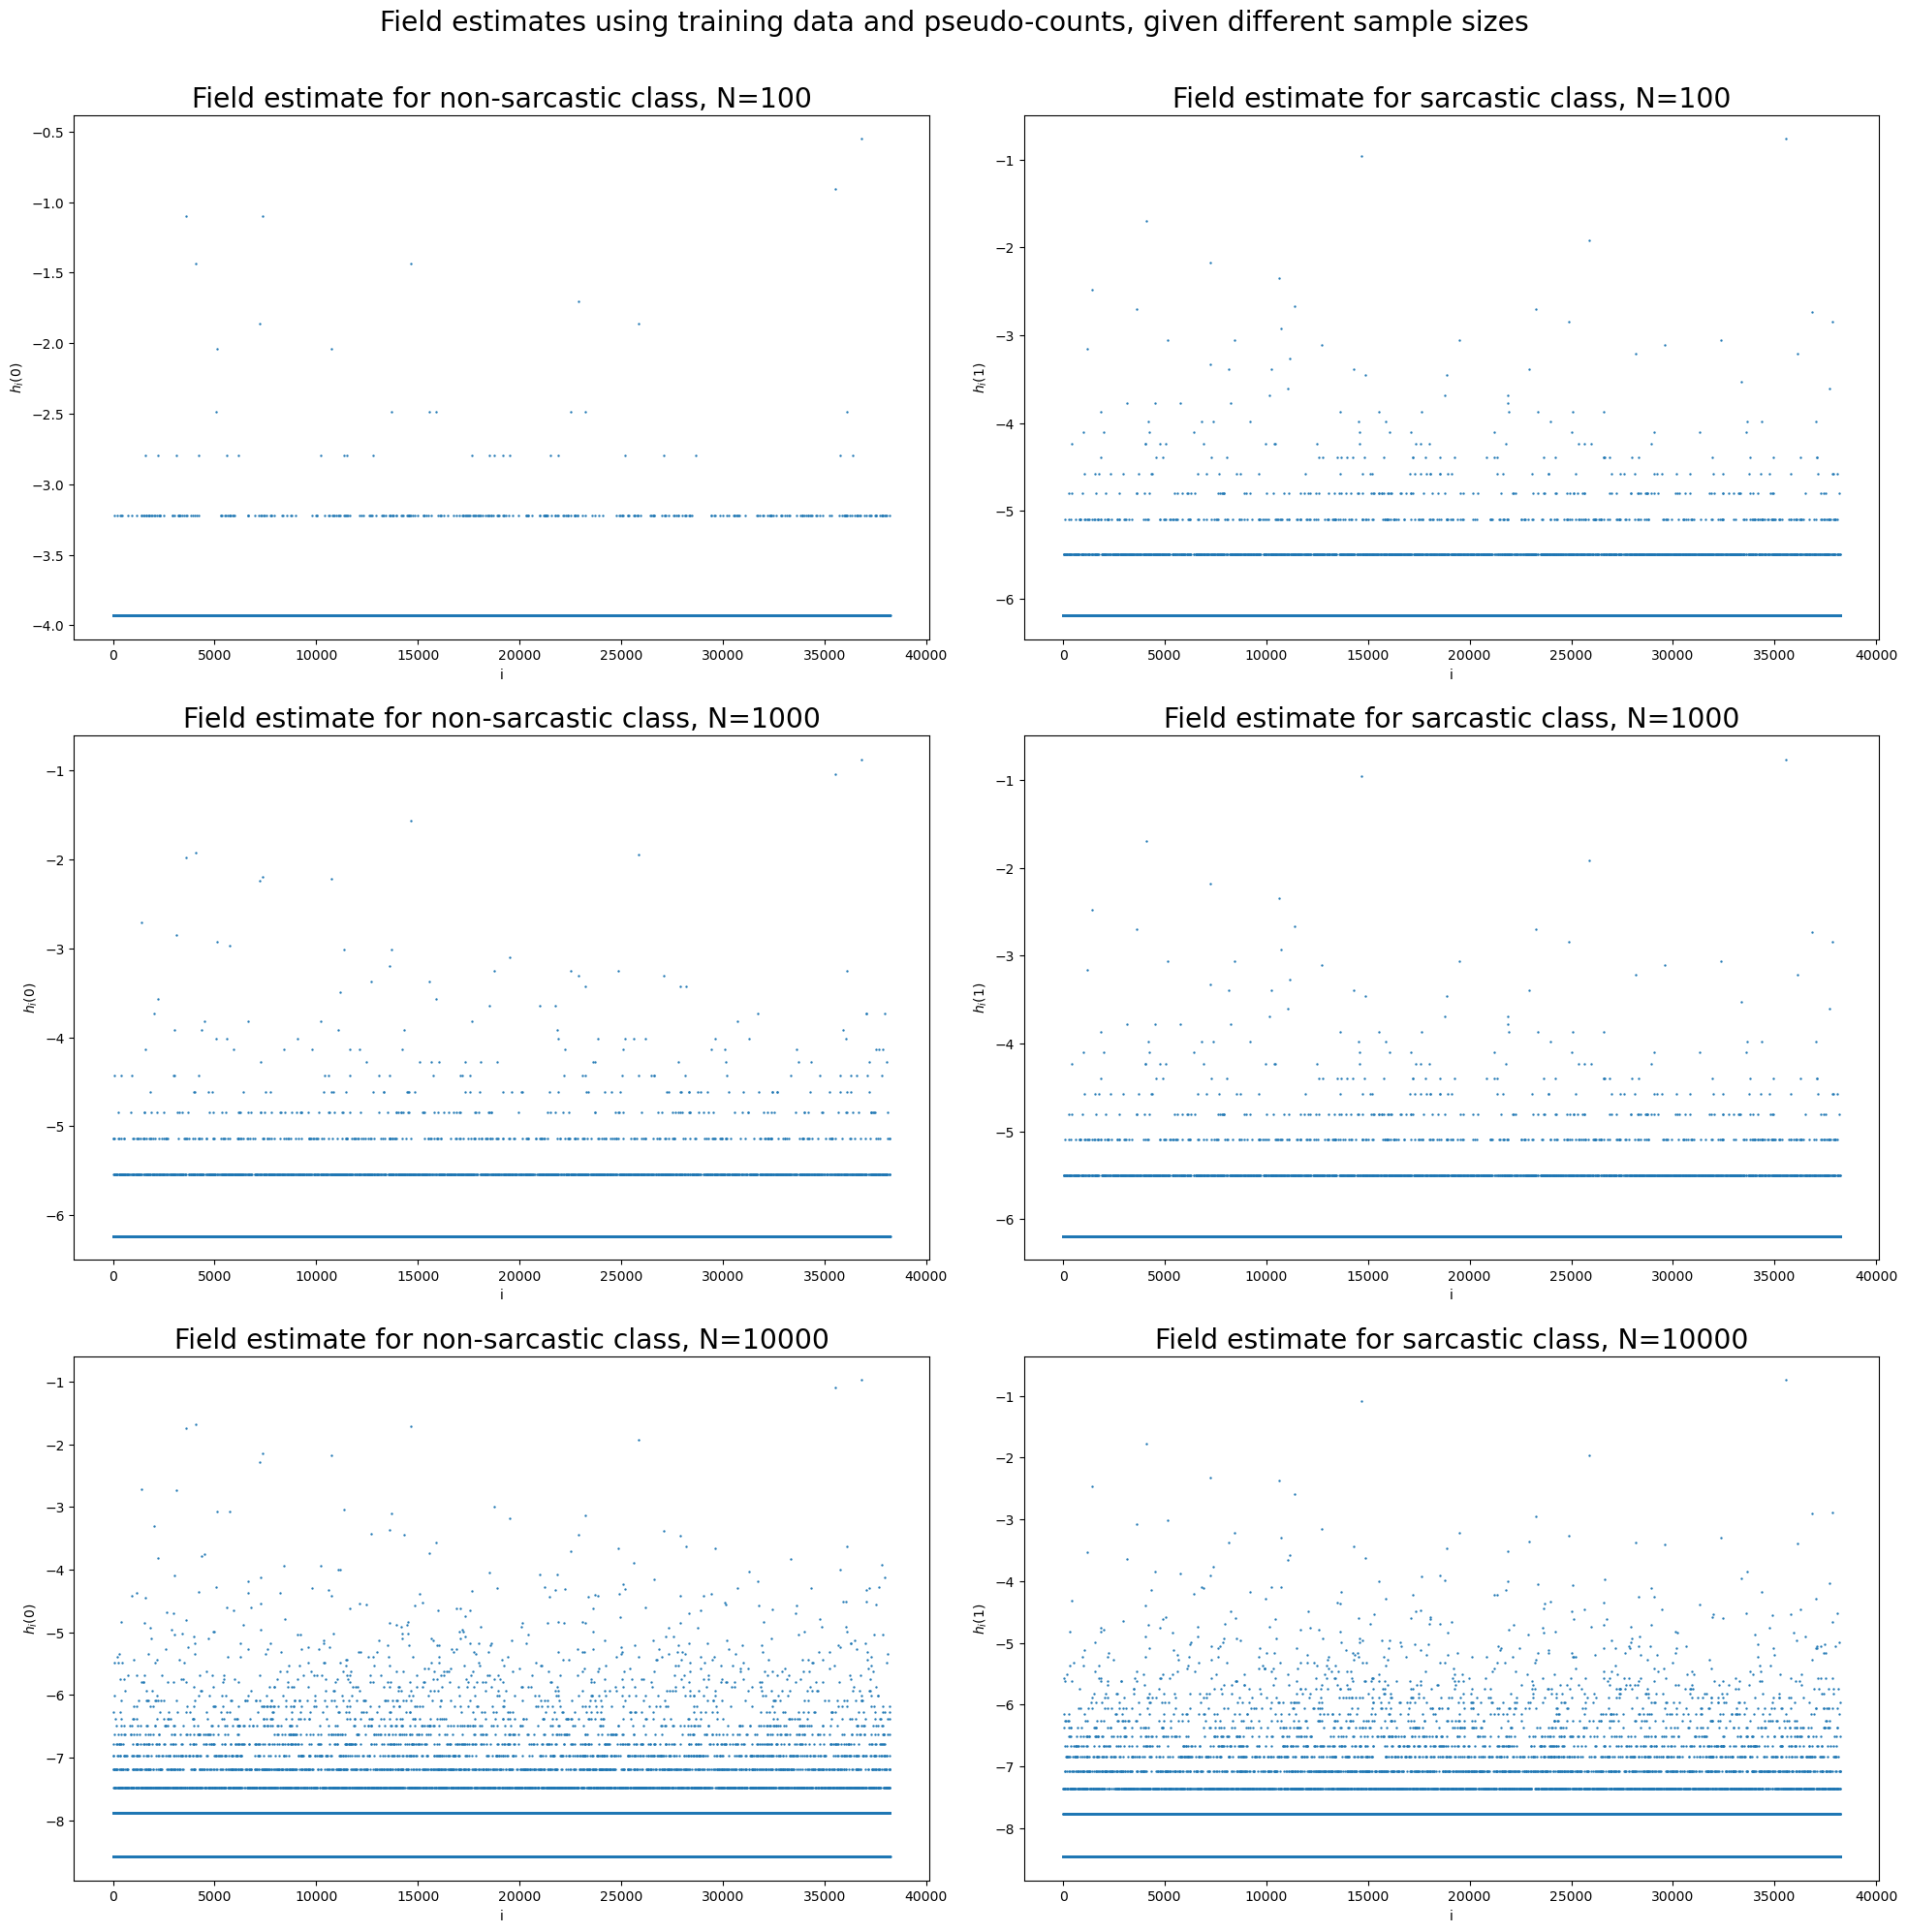

In [29]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 20))

# Increase font size
plt.rcParams.update({'font.size': 17})
fig.suptitle('Field estimates using training data and pseudo-counts, given different sample sizes', y = 1)

ax1.scatter([i for i in range(len(field_non_sarcastic_train_100))], field_non_sarcastic_train_100, s=0.5)
ax1.set_xlabel('i')
ax1.set_ylabel(r'$h_i(0)$')
ax1.set_title('Field estimate for non-sarcastic class, N=100')

ax2.scatter([i for i in range(len(field_sarcastic_train_100))], field_sarcastic_train_1000, s=0.5)
ax2.set_xlabel('i')
ax2.set_ylabel(r'$h_i(1)$')
ax2.set_title('Field estimate for sarcastic class, N=100')

ax3.scatter([i for i in range(len(field_non_sarcastic_train_1000))], field_non_sarcastic_train_1000, s=0.5)
ax3.set_xlabel('i')
ax3.set_ylabel(r'$h_i(0)$')
ax3.set_title('Field estimate for non-sarcastic class, N=1000')

ax4.scatter([i for i in range(len(field_sarcastic_train_1000))], field_sarcastic_train_1000, s=0.5)
ax4.set_xlabel('i')
ax4.set_ylabel(r'$h_i(1)$')
ax4.set_title('Field estimate for sarcastic class, N=1000')


ax5.scatter([i for i in range(len(field_non_sarcastic_train_10000))], field_non_sarcastic_train_10000, s=0.5)
ax5.set_xlabel('i')
ax5.set_ylabel(r'$h_i(0)$')
ax5.set_title('Field estimate for non-sarcastic class, N=10000')

ax6.scatter([i for i in range(len(field_sarcastic_train_10000))], field_sarcastic_train_10000, s=0.5)
ax6.set_xlabel('i')
ax6.set_ylabel(r'$h_i(1)$')
ax6.set_title('Field estimate for sarcastic class, N=10000')



fig.tight_layout()
# fig.savefig('fields_Ns.png', dpi=600)

In [30]:
pcond_s_100 = np.exp(log_conditional(tests_data, field_sarcastic_train_100))
pcond_ns_100 = np.exp(log_conditional(tests_data, field_non_sarcastic_train_100))

pcond_s_1000 = np.exp(log_conditional(tests_data, field_sarcastic_train_1000))
pcond_ns_1000 = np.exp(log_conditional(tests_data, field_non_sarcastic_train_1000))

pcond_s_10000 = np.exp(log_conditional(tests_data, field_sarcastic_train_10000))
pcond_ns_10000 = np.exp(log_conditional(tests_data, field_non_sarcastic_train_10000))

y_100 = avoid_zero_div(pcond_s_100,pcond_ns_100)
y_1000 = avoid_zero_div(pcond_s_1000,pcond_ns_1000)
y_10000 = avoid_zero_div(pcond_s_10000,pcond_ns_10000)

In [31]:
#Q3b ROC and AUC

fpr_100, tpr_100, thresholds = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_100)
fpr_1000, tpr_1000, thresholds = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_1000)
fpr_10000, tpr_10000, thresholds = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_10000) 

# Calculate Area Under the Curve (AUC)
roc_auc_100 = auc(fpr_100, tpr_100)
roc_auc_1000 = auc(fpr_1000, tpr_1000)
roc_auc_10000 = auc(fpr_10000, tpr_10000)


y_random = np.random.rand(len(tests_data))
fpr_random, tpr_random, _ = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_random)
roc_auc_random = auc(fpr_random, tpr_random)

y_perfect = [doc['is_sarcastic'] for doc in tests_data]
fpr_perfect, tpr_perfect, _ = roc_curve([doc['is_sarcastic'] for doc in tests_data], y_perfect)
roc_auc_perfect = auc(fpr_perfect, tpr_perfect)

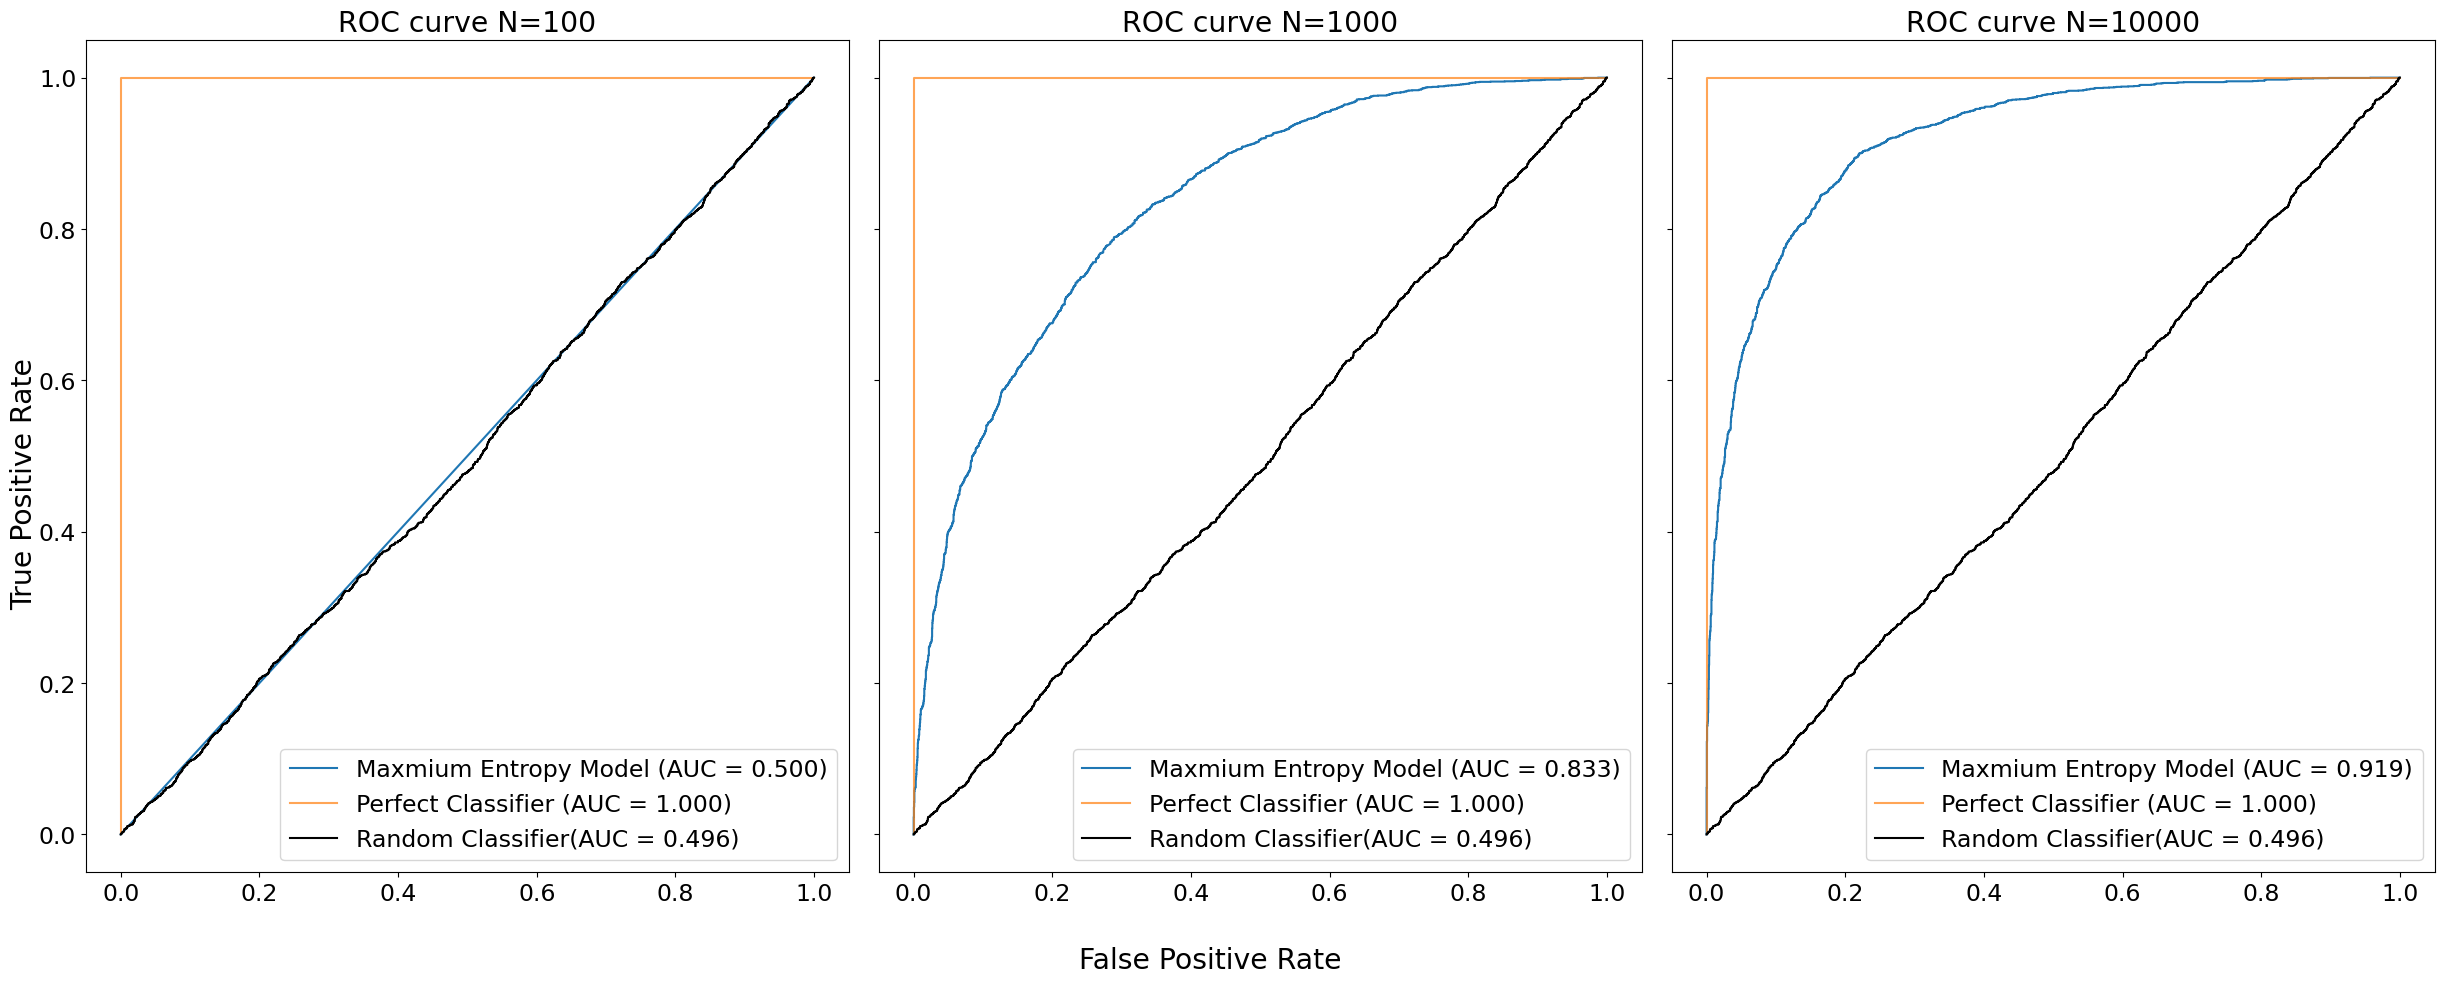

In [32]:
# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 17})
ax1.plot(fpr_100, tpr_100,  
         label=f'Maxmium Entropy Model (AUC = {roc_auc_100:.3f})')
ax1.plot(fpr_perfect, tpr_perfect, alpha=0.7, label=f'Perfect Classifier (AUC = {roc_auc_perfect:.3f})')
ax1.plot(fpr_random, tpr_random, color='black',
         label=f'Random Classifier(AUC = {roc_auc_random:.3f})')
ax1.legend(loc='lower right')

ax1.set_title('ROC curve N=100')

ax2.plot(fpr_1000, tpr_1000,
            label=f'Maxmium Entropy Model (AUC = {roc_auc_1000:.3f})')
ax2.plot(fpr_perfect, tpr_perfect, alpha=0.7, label=f'Perfect Classifier (AUC = {roc_auc_perfect:.3f})')
ax2.plot(fpr_random, tpr_random, color='black',
        label=f'Random Classifier(AUC = {roc_auc_random:.3f})')
ax2.legend(loc='lower right')
ax2.set_title('ROC curve N=1000')

ax3.plot(fpr_10000, tpr_10000,
            label=f'Maxmium Entropy Model (AUC = {roc_auc_10000:.3f})')
ax3.plot(fpr_perfect, tpr_perfect, alpha=0.7, label=f'Perfect Classifier (AUC = {roc_auc_perfect:.3f})')
ax3.plot(fpr_random, tpr_random, color='black',
        label=f'Random Classifier(AUC = {roc_auc_random:.3f})')
ax3.legend(loc='lower right')
ax3.set_title('ROC curve N=10000')

fig.supylabel('True Positive Rate')
fig.supxlabel('False Positive Rate')

fig.tight_layout()
# fig.savefig('roc_auc_Ns.png', dpi=600)


# Appendix: ROC and AUC

Giving predicted scores $S_i$ (in the exercises above you will use the odds ratio $P(c=1|\vec\sigma)/P(c=0|\vec\sigma)$ of the headlines $\vec\sigma_i$, and their true labels, $y_i=0,1$, we consider a threshold $t$ and assume that headlines for which $S_i > t$ are predicted to be sarcastic, while those for which $S_i\le t$ are predicted to be non-sarcastic. We define:

$$TP(t) = \text{number of true positives}\quad
(S_i > t\, \text{and}\, y_i=1)$$
$$FP(t) = \text{number of false positives}\quad
(S_i > t\, \text{and}\, y_i=0)$$

That is, $TP(t)$ is the number of correctly classified positive (sarcastic) headlines, and $FP(t)$ is the number of wrongly classified negative (non-sarcastic) headlines. In addition, let $P$ be the total number of sarcastic headlines in the data, and $N$ the total number of non-sarcastic headlines. Finally we define:

$$TPR(t) = \frac{TP(t)}{P} ,\qquad FPR(t) = \frac{FP(t)}{N}$$

The ROC curve is defined as the parametric curve $(FPR(t), TPR(t))$, traversed as the threshold takes all possible values, $-\infty<t<\infty$. Notice that $0\le TPR(t)\le1$ and $0\le FPR(t)\le1$, and that:

$$TPR(-\infty)=FPR(-\infty)=1,\qquad TPR(\infty)=FPR(\infty)=0$$

The AUC is defined as the area under this curve:

$$AUC = \int_{t=-\infty}^\infty TPR(t) \times \mathrm d FPR(t)
= \int_{t=-\infty}^\infty TPR(t) \times \frac{\mathrm d FPR(t)}{\mathrm d t} \mathrm{d}t$$